    # 0. Install and Import Dependencies

In [1]:
import os
from typing import List

import cv2
import tensorflow as tf
from matplotlib import pyplot as plt

2024-04-18 00:03:36.380752: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-18 00:03:36.405388: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 00:03:36.405410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 00:03:36.406258: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 00:03:36.410645: I tensorflow/core/platform/cpu_feature_guar

In [2]:

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
tf.config.list_physical_devices('GPU')

2024-04-18 00:03:37.633726: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-18 00:03:37.657661: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-18 00:03:37.657824: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
MOUTH_W, MOUTH_H = 140, 70

# 1. Build Data Loading Functions

In [4]:
import numpy as np

cv2_base_dir = os.path.dirname(os.path.abspath(cv2.__file__))
haar_model = os.path.join(cv2_base_dir, 'data/haarcascade_frontalface_default.xml')

lip_cascade = cv2.CascadeClassifier(haar_model)


def mouth_extractor(file_path: str, scale_factor=1.3, min_neighbors=5, mouth_size=(MOUTH_W, MOUTH_H)) -> None:
    base_path = file_path.split('.')[0]
    # if not os.path.exists(base_path + '.npy'):
    if file_path.endswith('.mpg'):
        cap = cv2.VideoCapture(file_path)
        if not cap.isOpened():
            raise Exception("Error: Could not open video.")
        frames = []
        for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
            ret, frame = cap.read()
            if not ret:
                raise Exception("Error: Could not read frame.")
            # Convert to grayscale

            # faces = lip_cascade.detectMultiScale(frame, scale_factor, min_neighbors)
            # if len(faces) == 0:
            #     print(f'Error: No face detected in {file_path}')
            #     continue
            frame = frame[180:250, 100:220, :]
            frame = cv2.resize(frame, mouth_size)
            frame = tf.image.rgb_to_grayscale(frame)
            frames.append(frame)
            # for (x, y, w, h) in faces:
            #     mouth_roi = frame[y + int(h / 2):y + h, x:x + w, :]

            #     frame = tf.image.rgb_to_grayscale(frame)
            #     frames.append(frame)

        cap.release()
        # if len(frames) < 62:
        #     print(f'Error: {file_path} has less than 62 frames,rather drop out', len(frames))
        #     return
        # Normalize frames
        mean = tf.math.reduce_mean(frames)  # compute the mean
        std = tf.math.reduce_std(tf.cast(frames, tf.float32))
        frames_tensor = tf.cast((frames - mean), tf.float32) / std
        # Save as npy file
        np.save(base_path + '.npy', frames_tensor)
        return frames_tensor
    else:
        raise Exception("Error: File format not supported.")


In [5]:
test_path = '/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s18/bbad5n.mpg'
frames = mouth_extractor(test_path)


2024-04-18 00:03:37.684493: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-18 00:03:37.684710: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-18 00:03:37.684810: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
print(frames.shape)

(75, 70, 140, 1)


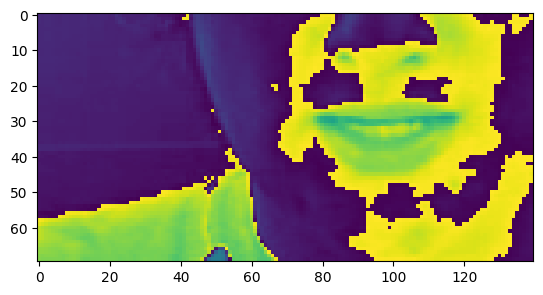

In [7]:
plt.imshow(frames[44][:, :, 0])

In [8]:
import glob
import time
import tqdm

DIR = '/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/'  #absolute path
time1 = time.time()
video_list = glob.glob(DIR + '/**/*.mpg', recursive=True)
for video in tqdm.tqdm(video_list, total=len(video_list)):
    # mouth_extractor(video)
    pass


100%|██████████| 9999/9999 [00:00<00:00, 10083877.30it/s]


In [9]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz "]

In [10]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' '] (size =28)


In [11]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 ' ']

In [12]:
char_to_num(['n', 'i', 'c', 'k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [13]:
num_to_char([14, 9, 3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [14]:
# def load_alignments(path:str) -> List[str]: 
#     with open(path, 'r') as f: 
#         lines = f.readlines() 
#     tokens = []
#     for line in lines:
#         line = line.split()
#         if line[2] != 'sil': 
#             tokens = [*tokens,' ',line[2]]
#     return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]
def init_alignments() -> dict[str:List[str]]:
    alignments = {}
    align_list = glob.glob(DIR + '/**/*.align', recursive=True)
    for align in tqdm.tqdm(align_list, total=len(align_list)):
        if align.endswith('.align'):
            file = align.split('/')[-1]
            with open(align, 'r') as f:
                lines = f.readlines()
            tokens = []
            for line in lines:
                line = line.split()
                if line[2] != 'sil':
                    tokens = [*tokens, ' ', line[2]]
            alignments[file] = char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[
                               1:]
    return alignments


alignments_dict = init_alignments()
# get the max length of the alignments
max_len = max([len(x) for x in alignments_dict.values()])


100%|██████████| 34000/34000 [00:48<00:00, 695.90it/s]


In [15]:
print(len(alignments_dict))
print(max_len)

34000
41


In [16]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    filepath = path.split('.')[0]
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = f'{filepath}.npy'
    alignment_path = f'{file_name}.align'
    frames = np.load(video_path, allow_pickle=True)
    alignments = alignments_dict.get(alignment_path)
    if alignments is None:
        return 'hello world'
    if frames is None:
        raise Exception(f'Error: No video found for {path}')
    return frames, alignments

In [17]:
test_path = '/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s17/bbad6n.mpg'

In [18]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbad6n'

In [19]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [20]:
print(len(frames))

75


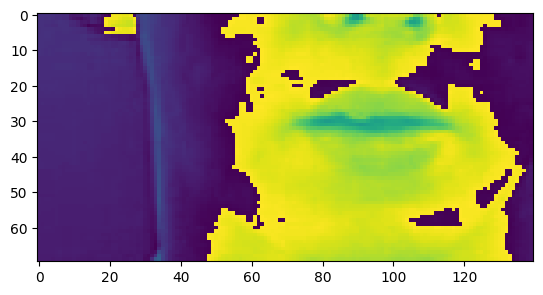

In [21]:
plt.imshow(frames[45][:, :, 0])


In [22]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 27,  2, 12, 21,  5, 27,  1, 20, 27,  4, 27, 19,  9, 24,
       27, 14, 15, 23])>

In [23]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at d six now'>

In [24]:
def mappable_function(path: str) -> List[str]:
    result = tf.py_function(load_data, [path], (
        tf.float16, tf.int64))  # py_function is used to convert a python function to a tensorflow function
    return result

# 2. Create Data Pipeline

In [54]:
data = tf.data.Dataset.list_files(DIR + '**/*.mpg', shuffle=False)  # list all the files
data = data.shuffle(500, reshuffle_each_iteration=True)
data = data.map(mappable_function, num_parallel_calls=tf.data.AUTOTUNE)  # map the function to the data
#automoatically pad the largest one
data = data.padded_batch(4, padded_shapes=([75, 70, 140, 1], [41]))
data = data.prefetch(tf.data.AUTOTUNE)  # prefetch the data
# Added for split 
train = data.take(int(len(data) * 0.8))
test = data.skip(int(len(data) * 0.8))

In [26]:
print(len(data))
print(len(train))
print(len(test))

2500
2000
500


In [27]:
frames, alignments = data.as_numpy_iterator().next()

In [28]:
len(frames)

4

In [29]:
sample = data.as_numpy_iterator()

In [30]:
val = sample.next();
val[0].shape

(4, 75, 70, 140, 1)

In [31]:
# import imageio
# 
# imageio.mimsave('./animation.gif', val[0][0], fps=10)  # can't handle this data type:(1,1,1), <f4
# imageio.mimsave('./animation.gif', val[0][0].astype(np.uint8), fps=10)


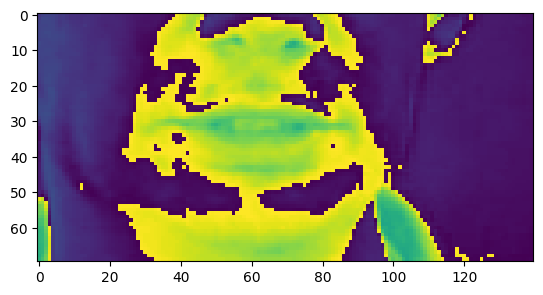

In [32]:
# plt show the image with RGB
#Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
import matplotlib.pyplot as plt

# Assuming `rgb_image` is your numpy array containing RGB values
rgb_image = val[0][0][34][:, :, 0]
plt.imshow(rgb_image)
plt.show()



In [33]:
# calculate the wer and cer
import jiwer


def calculate_wer(true_texts, pred_texts):
    transformation = jiwer.Compose([
        jiwer.ToLowerCase(),
        jiwer.RemoveMultipleSpaces(),
        jiwer.RemovePunctuation(),
        jiwer.Strip(),
        jiwer.ReduceToListOfListOfWords(word_delimiter=" ")
    ])
    wer = jiwer.wer(true_texts, pred_texts, truth_transform=transformation, hypothesis_transform=transformation)
    return wer


def calculate_cer(true_texts, pred_texts):
    transformation = jiwer.Compose([
        jiwer.ToLowerCase(),
        jiwer.RemoveMultipleSpaces(),
        jiwer.RemovePunctuation(),
        jiwer.Strip(),
        jiwer.ReduceToListOfCharacters()
    ])
    cer = jiwer.cer(true_texts, pred_texts, truth_transform=transformation, hypothesis_transform=transformation)
    return cer

In [34]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay green in f three again'>

# 3. Design the Deep Neural Network

In [35]:
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, TimeDistributed, \
    Flatten
from tensorflow.keras.models import Sequential

In [36]:
data.as_numpy_iterator().next()[0][0].shape

(75, 70, 140, 1)

In [37]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 70, 140, 1), padding='same'))  # 128 filters, 3x3 kernel
model.add(Activation('relu'))  # activation function
model.add(MaxPool3D((1, 2, 2)))  # max pooling

model.add(Conv3D(256, 3, padding='same'))  # 256 filters, 3x3 kernel
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))  # flatten the output of the previous layer

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))  # bidirectional LSTM
model.add(Dropout(0.5))  # dropout layer

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(
    Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))  # output layer


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 70, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 70, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 35, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 35, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 35, 70, 256)   0         
                                                        

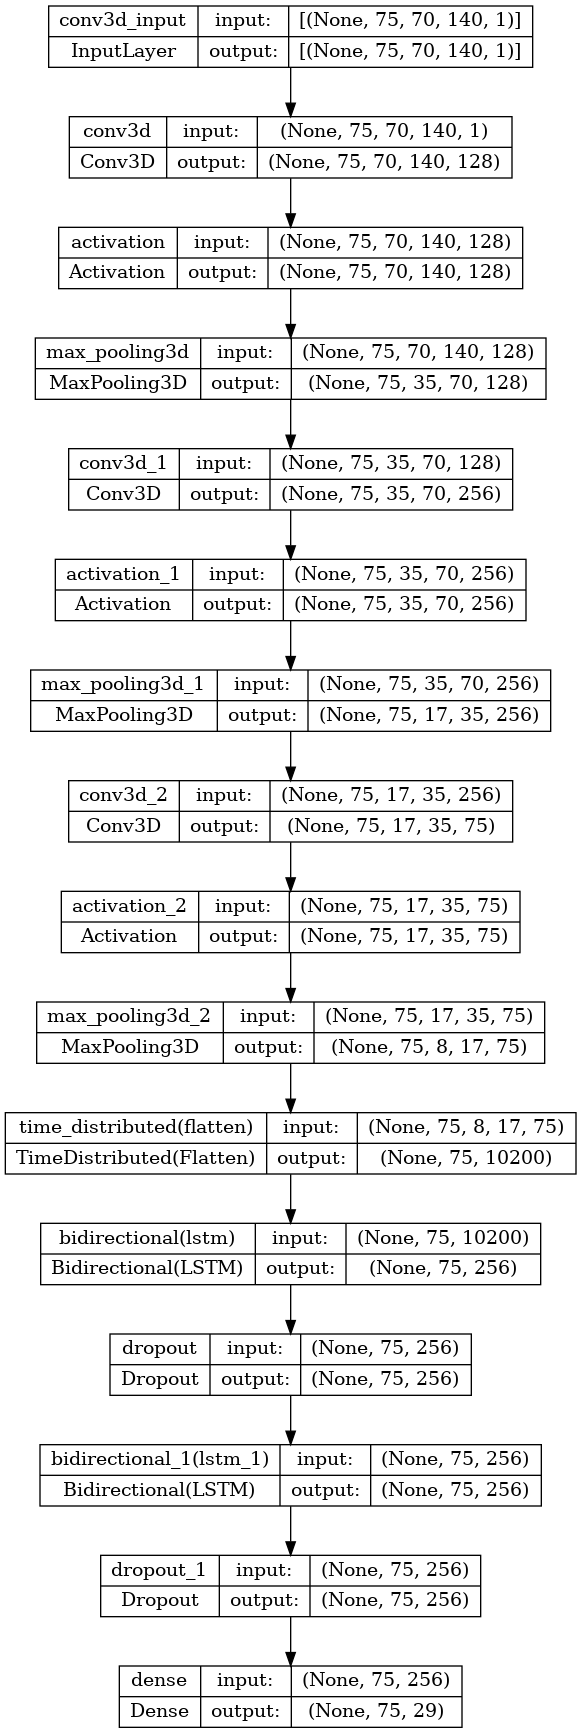

In [38]:
model.summary()
# save as a picture
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='base_line_model_with_layers_140*70.png', show_shapes=True, show_layer_names=True)

In [39]:
8 * 17 * 75

10200

In [40]:
yhat = model.predict(val[0])

2024-04-18 00:04:29.640372: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-18 00:04:29.692581: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 11s 11s/step


In [41]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0], axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'ssssssssssssssssssssssssssaasssaaaaaaaaaaaaaaaaavvvvvvvvaaaaaaaaaaaass'>

In [42]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'ssssssssssssssssssssssssssaasssaaaaaaaaaaaaaaaaavvvvvvvvaaaaaaaaaaaass'>

In [43]:
model.input_shape

(None, 75, 70, 140, 1)

In [44]:
model.output_shape

(None, 75, 29)

# 4. Setup Training Options and Train

In [45]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [46]:
def scheduler(epoch, lr):  # learning rate scheduler
    if epoch % 10 != 0 or epoch == 0:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [47]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [48]:
from jiwer import wer, cer


class PeriodicWER_CERCallback(tf.keras.callbacks.Callback):
    def __init__(self, train_data, val_data, period=4):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.period = period

    # def on_batch_end(self, batch, logs=None):
    #     logs = logs or {}
    #     if (batch + 1) % self.period == 0:
    #         train_wer, train_cer = self.compute_wer_cer(self.train_data)
    #         val_wer, val_cer = self.compute_wer_cer(self.val_data)
    # 
    #         # 
    #         logs['train_wer'] = train_wer
    #         logs['train_cer'] = train_cer
    #         logs['val_wer'] = val_wer
    #         logs['val_cer'] = val_cer
    # 
    #         print(
    #             f"Epoch {batch + 1}: Train WER: {train_wer:.4f}, Train CER: {train_cer:.4f}, Val WER: {val_wer:.4f}, Val CER: {val_cer:.4f}")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if (epoch + 1) % self.period == 0:
            train_wer, train_cer = self.compute_wer_cer(self.train_data)
            val_wer, val_cer = self.compute_wer_cer(self.val_data)

            # 
            logs['train_wer'] = train_wer
            logs['train_cer'] = train_cer
            logs['val_wer'] = val_wer
            logs['val_cer'] = val_cer

            print(
                f"Epoch {epoch + 1}: Train WER: {train_wer:.4f}, Train CER: {train_cer:.4f}, Val WER: {val_wer:.4f}, Val CER: {val_cer:.4f}")

    def compute_wer_cer(self, data):
        # Gather all predictions and true labels
        all_preds, all_trues = [], []
        for batch in data:
            x, y_true = batch
            y_pred = self.model.predict(x)
            decoded_preds, decoded_trues = self.decoded_predictions(y_pred, y_true)
            all_preds.extend(decoded_preds)
            all_trues.extend(decoded_trues)

        # Calculate WER and CER using jiwer
        return wer(all_trues, all_preds), cer(all_trues, all_preds)

    def decoded_predictions(self, yhat, y_true):
        decoded_logits = \
            tf.keras.backend.ctc_decode(yhat, input_length=[75] * len(yhat), greedy=True)[0][0]
        decoded_pred = [tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8') for
                        sentence in decoded_logits]
        decoded_true = [tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8') for
                        sentence in y_true]
        return decoded_pred, decoded_true





In [49]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)
# model.load_weights('models/lip_reading_baseline_140*70.h5')

In [50]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'lip_reading_140*70.h5'), monitor='val_loss',
                                      save_weights_only=True, save_freq=1, )

In [51]:
schedule_callback = LearningRateScheduler(scheduler)
wer_cer_callback = PeriodicWER_CERCallback(train, test, 10)

In [52]:
from datetime import datetime

log_dir = "logs/fit/" + datetime.now().strftime("%Y-%m-%d-%H%M")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [55]:
model.fit(train, validation_data=test, epochs=60, workers=4, initial_epoch=44,
          callbacks=[checkpoint_callback, schedule_callback, wer_cer_callback, tensorboard_callback])

# caculate the loss

Epoch 45/60
2000/2000 [==============================] - 1213s 606ms/step - loss: 7.0344 - val_loss: 54.5794 - lr: 6.7032e-05
Epoch 46/60
2000/2000 [==============================] - 1216s 608ms/step - loss: 5.9139 - val_loss: 53.8388 - lr: 6.7032e-05
Epoch 47/60
2000/2000 [==============================] - 1216s 608ms/step - loss: 5.3977 - val_loss: 55.5300 - lr: 6.7032e-05
Epoch 48/60
2000/2000 [==============================] - 1211s 606ms/step - loss: 4.8759 - val_loss: 54.2144 - lr: 6.7032e-05
Epoch 49/60
2000/2000 [==============================] - 1212s 606ms/step - loss: 5.0993 - val_loss: 56.8408 - lr: 6.7032e-05
Epoch 50/60
1/1 [==============================] - 0s 125ms/step
Epoch 50: Train WER: 0.0851, Train CER: 0.0218, Val WER: 0.4807, Val CER: 0.2953
2000/2000 [==============================] - 2017s 1s/step - loss: 4.6239 - val_loss: 57.4432 - lr: 6.7032e-05 - train_wer: 0.0851 - train_cer: 0.0218 - val_wer: 0.4807 - val_cer: 0.2953
Epoch 51/60
2000/2000 [==============

In [56]:
# model.evaluate(test)
loss_history = model.history.history

dict_keys(['loss', 'val_loss', 'lr', 'train_wer', 'train_cer', 'val_wer', 'val_cer'])


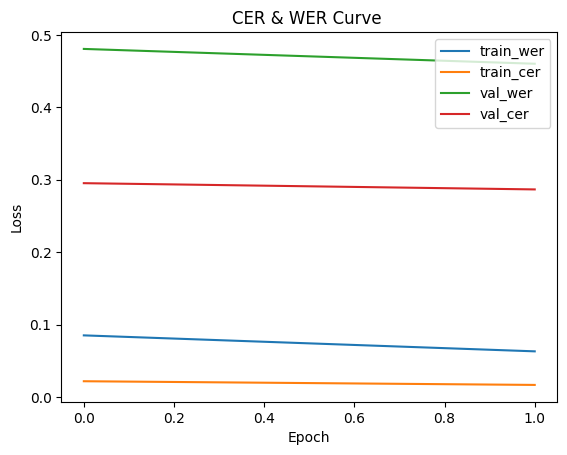

In [57]:
# draw the loss curve
print(loss_history.keys())
# plt.plot(loss_history['loss'], label='loss')
# plt.plot(loss_history['val_loss'], label='val_loss')
plt.plot(loss_history['train_wer'], label='train_wer')
plt.plot(loss_history['train_cer'], label='train_cer')
plt.plot(loss_history['val_wer'], label='val_wer')
plt.plot(loss_history['val_cer'], label='val_cer')
# x label and y label
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CER & WER Curve ')
plt.legend(loc='upper right')
filename = 'CER_WER_140*70_L.png'
plt.savefig(filename)
plt.show()


# 5. Make a Prediction 

In [ ]:
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# output = 'checkpoints.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('checkpoints.zip', 'models')

In [43]:
model.load_weights('models/lip_reading_baseline_140*70.h5')


In [44]:
## test on the test data
test_loss = model.evaluate(test)
print(f'Baseline The Test loss: {test_loss}')
# accuracy
accuracy = 100 - test_loss
print(f'Baseline Test accuracy with 140*70 {accuracy}')
# test on the train data
train_loss = model.evaluate(train)
print(f'Baseline The Train loss: {train_loss}')
accuracy = 100 -


2024-04-14 11:56:28.397233: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-14 11:56:28.535076: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


100/100 [==============================] - 22s 112ms/step - loss: 0.5198
Baseline The Test loss: 0.5197537541389465
Baseline Test accuracy with 140*70 99.48024624586105
400/400 [==============================] - 33s 82ms/step - loss: 0.4850
Baseline The Train loss: 0.48495984077453613


In [53]:
test_data = train.as_numpy_iterator()

In [54]:
sample = test_data.next()

In [55]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 93ms/step


In [56]:
print('~' * 100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set green by c six now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set white with c six please'>]

In [57]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75] * len(yhat), greedy=True)[0][0].numpy()

In [58]:
print('~' * 100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set green by c six now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set white with c six please'>]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('./data/s1/bbal6n.npy'))

In [ ]:
print('~' * 100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~' * 100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]